# Car insurance cold calls

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb

/Users/1aguschin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/1aguschin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Посмотрим на данные

In [2]:
train = pd.read_csv('carInsurance.csv')
train.shape

(4000, 19)

In [3]:
train[:5]

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [4]:
train.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


In [5]:
train.describe(include=['O'])

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,3098,4000,958,4000,4000
unique,11,3,3,2,12,3,3777,3764
top,management,married,secondary,cellular,may,failure,15:48:27,10:52:24
freq,893,2304,1988,2831,1049,437,3,3


# Корреляция

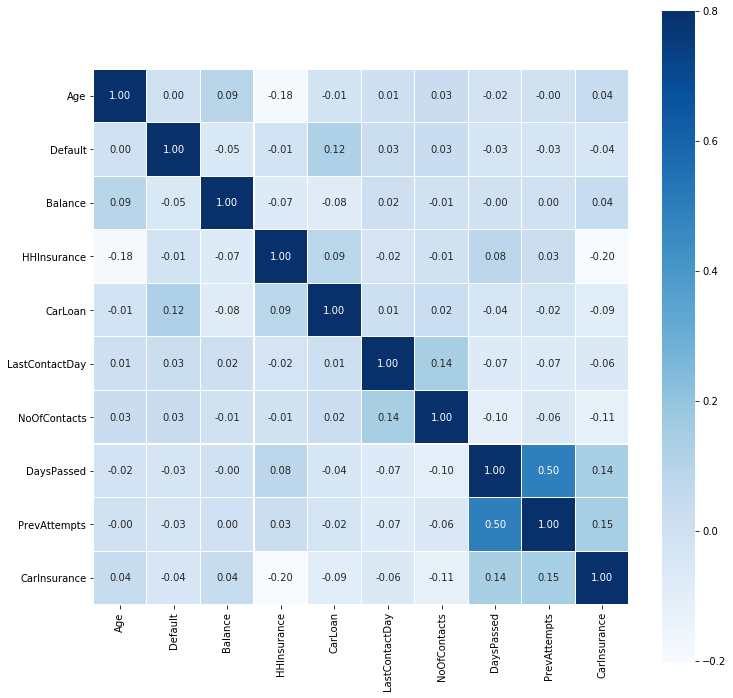

In [6]:
colormap = 'Blues'
cor = train.corr()
cor = cor.drop(['Id'],axis=1).drop(['Id'],axis=0)
plt.figure(figsize=(12,12))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

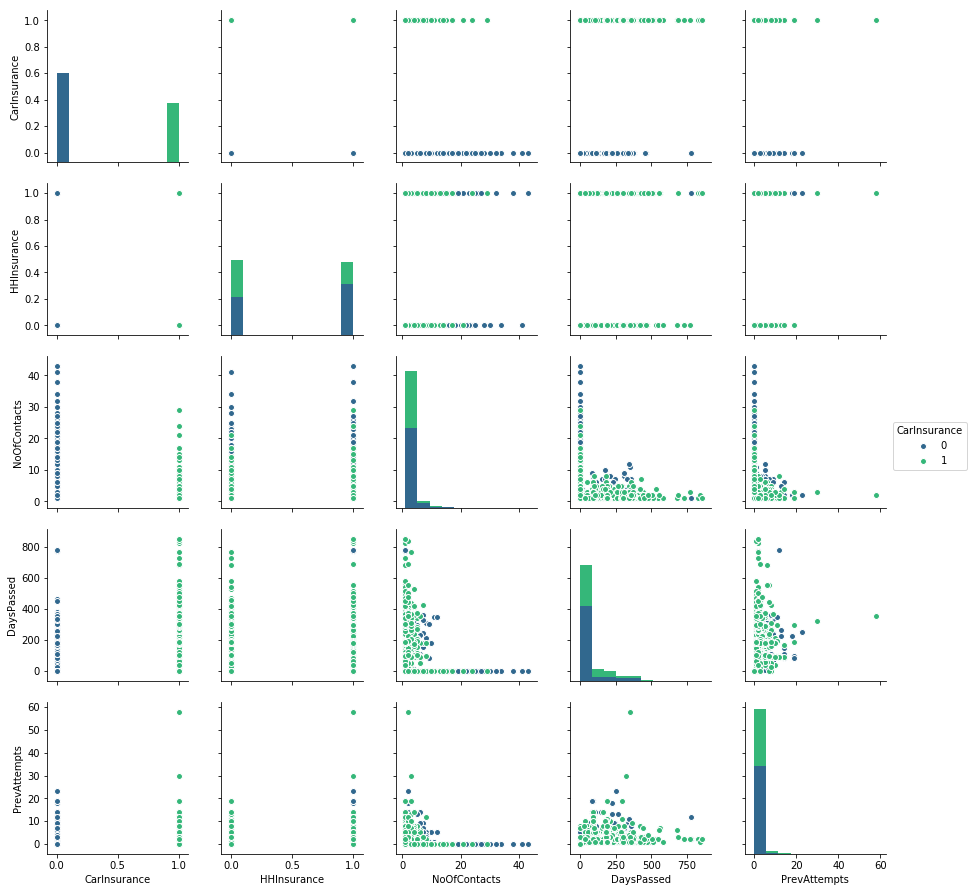

In [7]:
# Next, pair plot some important features
imp_feats = ['CarInsurance','HHInsurance','NoOfContacts','DaysPassed','PrevAttempts']
sns.pairplot(train[imp_feats],hue='CarInsurance',palette='viridis',size=2.5)
plt.show()

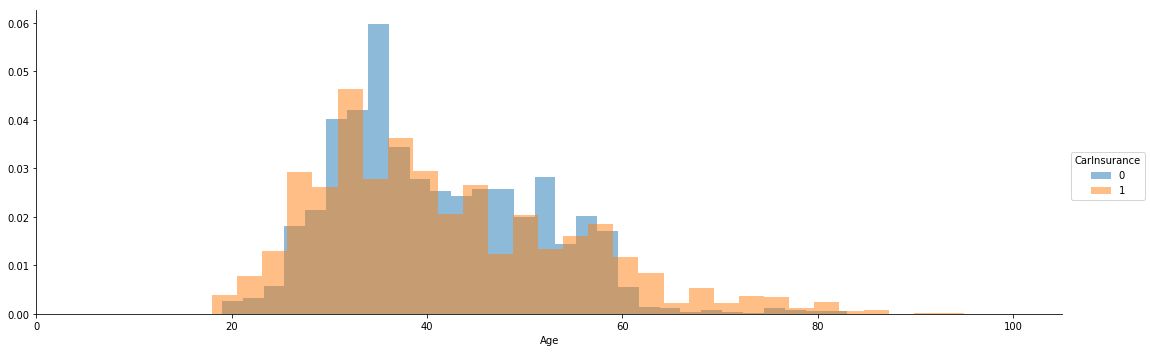

In [8]:
# Take a further look at Age
facet = sns.FacetGrid(train, hue='CarInsurance',size=5,aspect=3)
facet.map(plt.hist,'Age',bins=30,alpha=0.5,normed=True)
facet.set(xlim=(0,train.Age.max()+10))
facet.add_legend()

It looks like young people(<=30 years) and seniors are more likely to buy car insurance from this bank

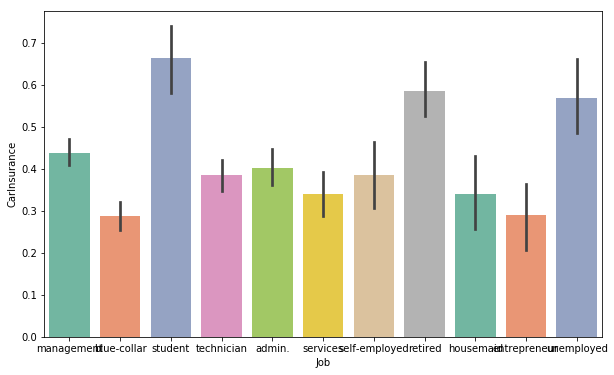

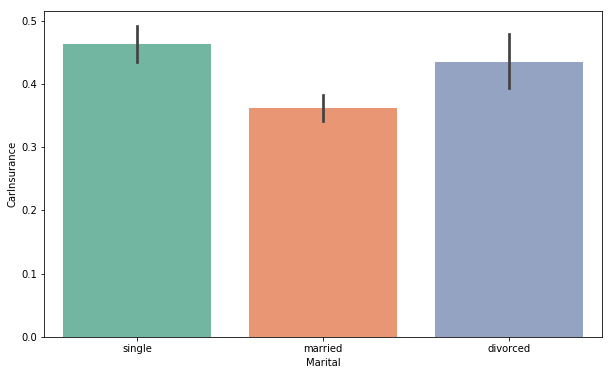

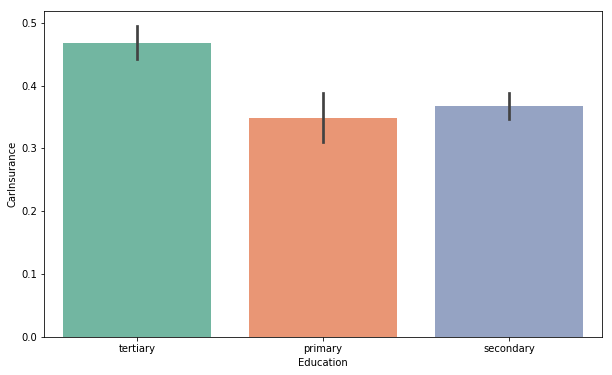

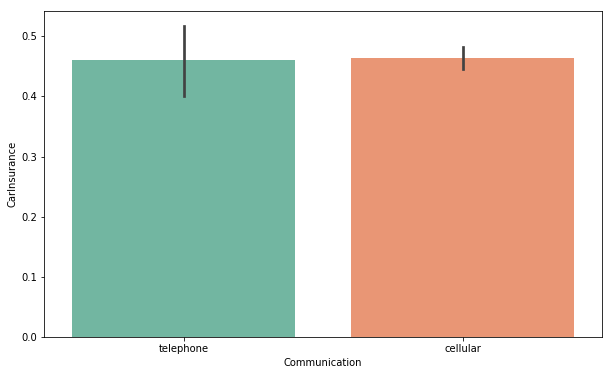

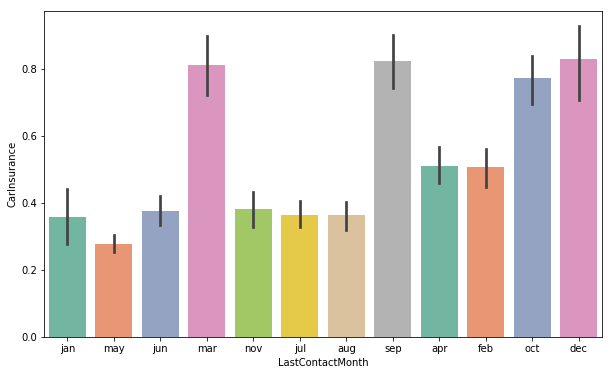

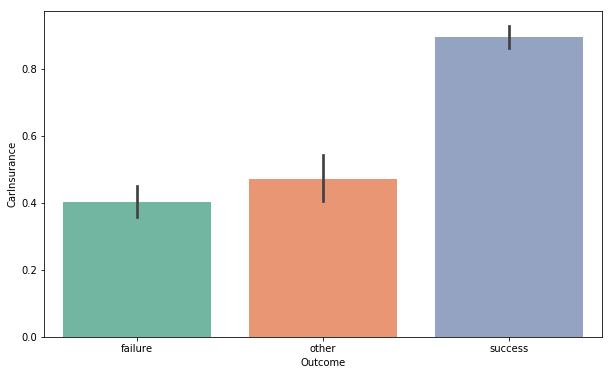

In [9]:
# Next check out categorical features
cat_feats = train.select_dtypes(include=['object']).columns
plt_feats = cat_feats[(cat_feats!= 'CallStart') & (cat_feats!='CallEnd')]

for feature in plt_feats:
    plt.figure(figsize=(10,6))
    sns.barplot(feature,'CarInsurance', data=train,palette='Set2') 

# Заполним пропуски

In [10]:
all = train.copy()
all.drop(['CarInsurance','Id'],axis=1,inplace=True)
print(all.shape)

(4000, 17)


In [11]:
total = all.isnull().sum()
pct = total/all.isnull().count()
NAs = pd.concat([total,pct],axis=1,keys=('Total','Pct'))
NAs[NAs.Total>0].sort_values(by='Total',ascending=False)

,Total,Pct
Outcome,3042,0.76050
Communication,902,0.22550
Education,169,0.04225
Job,19,0.00475


In [12]:
all_df = all.copy()

# Fill missing outcome as not in previous campaign
all_df[all_df['DaysPassed']==-1].count()
all_df.loc[all_df['DaysPassed']==-1,'Outcome']='NoPrev'

In [13]:
# Fill missing communication with none 
all_df['Communication'].value_counts()
all_df['Communication'].fillna('None',inplace=True)

In [15]:
# Fill missing education with the most common education level by job type
display(all_df['Education'].value_counts())

# Create job-education level mode mapping
edu_mode=[]
job_types = all_df.Job.value_counts().index
for job in job_types:
    mode = all_df[all_df.Job==job]['Education'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=all_df.Job.value_counts().index)

# Apply the mapping to missing eductaion obs
for j in job_types:
    all_df.loc[(all_df['Education'].isnull()) & (all_df['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]
all_df['Education'].fillna('None',inplace=True)

secondary    1988
tertiary     1281
primary       561
Name: Education, dtype: int64

In [16]:
# Fill missing job with none
all_df['Job'].fillna('None',inplace=True)

# Double check if there is still any missing value
all_df.isnull().sum().sum()

0

In [17]:
all_df.head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd
0,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NoPrev,13:45:20,13:46:30
1,32,blue-collar,married,primary,0,1156,1,0,None,26,may,5,-1,0,NoPrev,14:49:03,14:52:08
2,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04
3,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NoPrev,12:06:43,12:20:22
4,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NoPrev,14:35:44,14:38:56


# Добавим новые признаки

У нас есть три типа признаков
<br><b>Признаки клиента</b>: Age, Job, Marital, Education, Default, Balance, HHInsurance, CarLoan
<br><b>Признаки коммуникации</b>: LastContactDay, LastContactMonth, CallStart, CallEnd, Communication, NoOfContacts, DaysPassed
<br><b>Признаки из предыдущей маркетинговой компании</b>: PrevAttempts, Outcome

In [47]:
all_df.select_dtypes('O').apply(pd.Series.nunique)

Job                 12
Marital              3
Communication        3
LastContactMonth    12
Outcome              4
dtype: int64

In [19]:
all_df['Education'] = all_df['Education'].replace({'None':0,'primary':1,'secondary':2,'tertiary':3})

In [20]:
train_feat = train.groupby('Education').CarInsurance.value_counts().unstack()
print('amount:')
display(train_feat)
print('percentage:')
display(train_feat.div(train_feat.sum(1), axis='rows'))

amount:


CarInsurance,0,1
Education,,
primary,366,195
secondary,1258,730
tertiary,681,600


percentage:


CarInsurance,0,1
Education,,
primary,0.652406,0.347594
secondary,0.632797,0.367203
tertiary,0.531616,0.468384


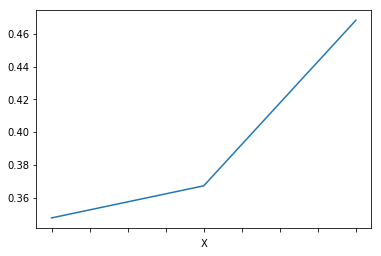

In [22]:
pd.DataFrame({'X': train.Education, 'y': train.CarInsurance}).groupby('X').y.mean().plot()

## закодируем категориальную переменную Job с помощью целевой переменной

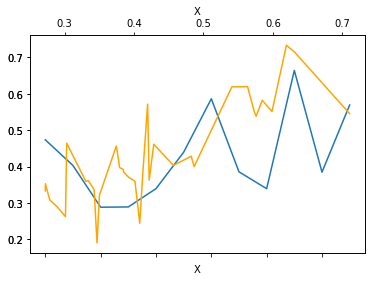

In [26]:
feature_to_encode = 'Job'

lm = LogisticRegression(C=1)
X = pd.get_dummies(all_df[[feature_to_encode]])
y = train.CarInsurance
feature_encoded = cross_val_predict(lm, X, y, method='predict_proba', cv=3) [:,1]

ax = pd.DataFrame({'X': all_df[feature_to_encode], 'y': y}).groupby('X').y.mean().plot()
pd.DataFrame({'X': feature_encoded, 'y': y}).groupby('X').y.mean().plot(ax=ax.twiny(), color='orange')

In [28]:
lm = LogisticRegression()

X = all_df[feature_to_encode].factorize(sort=True)[0].reshape(-1,1)
print(np.mean(cross_val_score(lm, X, y)))

X = feature_encoded.reshape(-1,1)
print(np.mean(cross_val_score(lm, X, y)))

0.5988997620841113
0.6249098362965473


## Добавим новые признаки на основе имеющихся временных

Text(0.5,1,'CallLength')

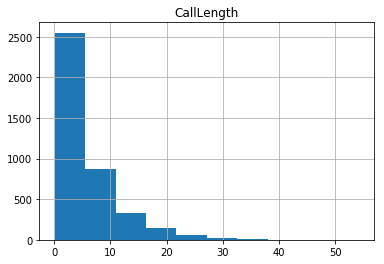

In [29]:
all_df['CallEnd'] = pd.to_datetime(all_df['CallEnd'])
all_df['CallStart'] = pd.to_datetime(all_df['CallStart'])
all_df['CallLength'] = ((all_df['CallEnd'] - all_df['CallStart'])/np.timedelta64(1,'m')).astype(float)

all_df['CallLength'].hist(); plt.title('CallLength')

Text(0.5,1,'CallStartHour')

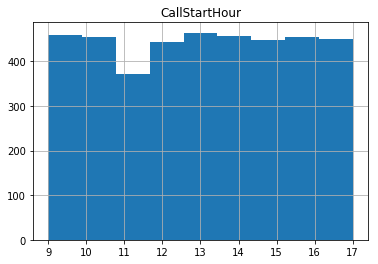

In [30]:
all_df['CallStartHour'] = all_df['CallStart'].dt.hour
all_df['CallStartHour'].hist(bins=9); plt.title('CallStartHour')

## Посчитаем дату последнего звонка клиенту

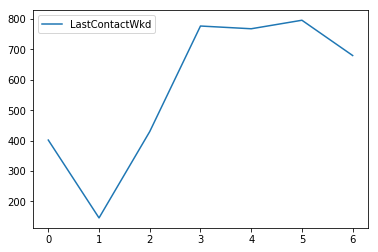

In [31]:
all_df['LastContactDate'] = all_df.apply(lambda x:datetime.datetime.strptime("%s %s %s" %(2016,x['LastContactMonth'],x['LastContactDay']),"%Y %b %d"),axis=1)

all_df['LastContactWkd'] = all_df['LastContactDate'].dt.weekday
pd.DataFrame(all_df['LastContactWkd'].value_counts()).sort_index().plot()

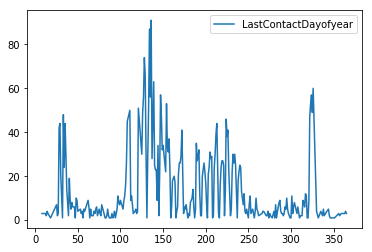

In [32]:
all_df['LastContactDayofyear'] = all_df['LastContactDate'].dt.dayofyear
pd.DataFrame(all_df['LastContactDayofyear'].value_counts()).sort_index().plot()

# Подготовим данные и выберем признаки перед обучением модели

In [33]:
# Spilt numeric and categorical features
cat_feats = all_df.select_dtypes(include=['object']).columns
num_feats = all_df.select_dtypes(include=['float64','int64']).columns
num_df = all_df[num_feats]
cat_df = all_df[cat_feats]
print('There are %d numeric features and %d categorical features\n' %(len(num_feats),len(cat_feats)))
print('Numeric features:\n',num_feats.values)
print('Categorical features:\n',cat_feats.values)

There are 14 numeric features and 5 categorical features

Numeric features:
 ['Age' 'Education' 'Default' 'Balance' 'HHInsurance' 'CarLoan'
 'LastContactDay' 'NoOfContacts' 'DaysPassed' 'PrevAttempts' 'CallLength'
 'CallStartHour' 'LastContactWkd' 'LastContactDayofyear']
Categorical features:
 ['Job' 'Marital' 'Communication' 'LastContactMonth' 'Outcome']


In [34]:
# One hot encoding
cat_df = pd.get_dummies(cat_df)

In [35]:
# Merge all features
all_data = pd.concat([num_df,cat_df],axis=1)

In [36]:
# Split train and test
train_df=all_data
train_label=train['CarInsurance']
print(train_df.shape)
print(len(train_label))

(3999, 48)
3999


In [37]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(train_df,train_label,test_size = 0.3,random_state=3)

# Обучение модели

In [38]:
# Create a cross validation function 
def get_best_model(estimator, params_grid={}):
    
    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(x_train,y_train)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [39]:
# Create a model fitting function
def model_fit(model,feature_imp=True,cv=5):

    clf = model.fit(x_train,y_train)
    y_pred = clf.predict_proba(x_test) [:,1]
    
    # model report
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    precision_recall_plot(precision, recall)

    print('\n--- Train Set -----------------------------')
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
    print('\n--- Validation Set -----------------------------')    
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
    print('-----------------------------------------------') 

    # feature importance 
    if feature_imp:
        try:
            imps = clf.feature_importances_
        except:
            imps = clf.coef_.ravel()

        feat_imp = pd.Series(imps,index=all_data.columns)
        feat_imp = feat_imp.nlargest(15).sort_values()
        plt.figure()
        feat_imp.plot(kind="barh",figsize=(6,8),title="Most Important Features")


In [40]:
from sklearn.metrics import precision_recall_curve

def precision_recall_plot(precision, recall):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0]); plt.grid()

### Logistic Regression


--- Best Parameters -----------------------------
{'C': 0.8, 'penalty': 'l1'}

--- Best Model -----------------------------
LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=3, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

--- Train Set -----------------------------
Accuracy: 0.82388 +/- 0.0111
AUC: 0.90923 +/- 0.0115

--- Validation Set -----------------------------
Accuracy: 0.80161 +/- 0.0184
AUC: 0.89483 +/- 0.0130
-----------------------------------------------


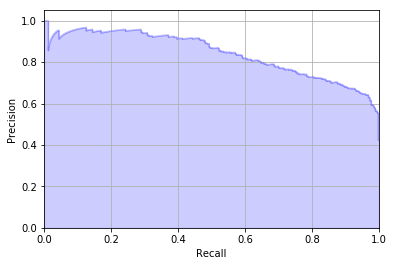

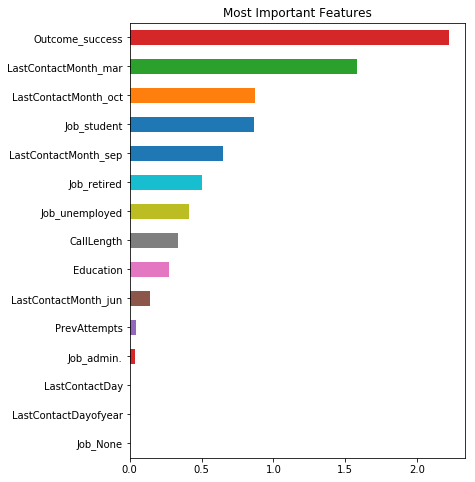

In [41]:
lg = LogisticRegression(random_state=3)
parameters = {'C':[0.8,0.9,1], 
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=True)

### Random Forest


--- Best Parameters -----------------------------
{'max_depth': 10, 'max_features': 14, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

--- Train Set -----------------------------
Accuracy: 0.84816 +/- 0.0107
AUC: 0.92385 +/- 0.0084

--- Validation Set -----------------------------
Accuracy: 0.82332 +/- 0.0147
AUC: 0.90824 +/- 0.0088
-----------------------------------------------


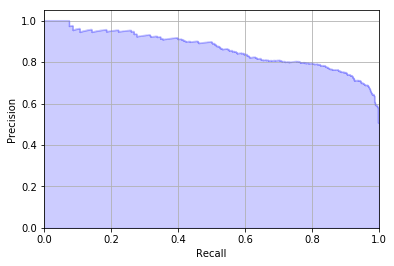

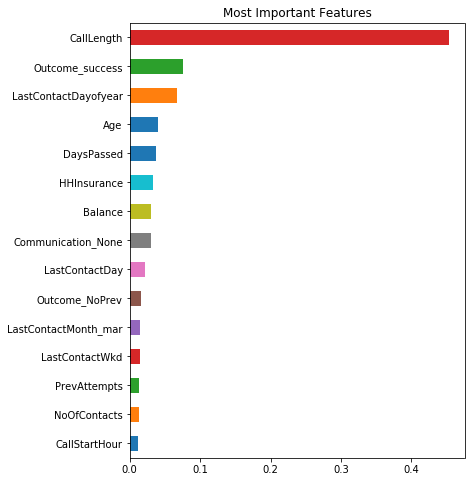

In [42]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
            'max_depth':[10],
            'max_features':[13,14],
            'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)
model_fit(model=clf_rf, feature_imp=True)

### XGBoost

In [43]:
import warnings
warnings.filterwarnings("ignore")


--- Best Parameters -----------------------------
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}

--- Best Model -----------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

--- Train Set -----------------------------
Accuracy: 0.85709 +/- 0.0046
AUC: 0.93314 +/- 0.0078

--- Validation Set -----------------------------
Accuracy: 0.82581 +/- 0.0113
AUC: 0.91567 +/- 0.0108
-----------------------------------------------


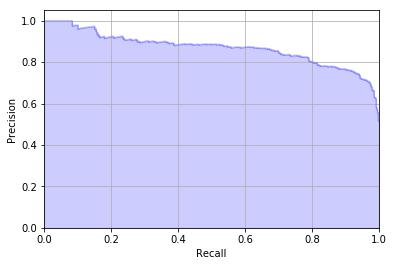

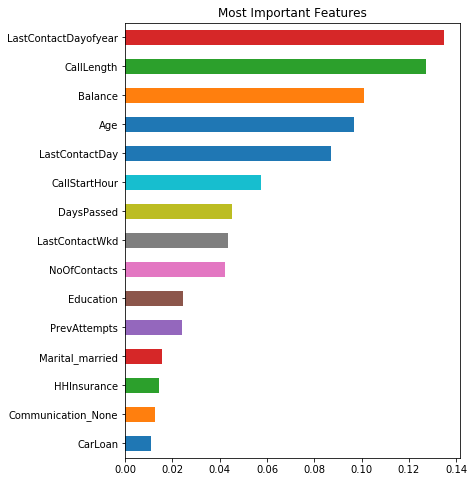

In [44]:
xgb = xgb.XGBClassifier()
parameters={'n_estimators':[500],#[900,1000,1100],
            'learning_rate':[0.01],
            'max_depth':[8],
            'min_child_weight':[1],
            'subsample':[0.8],
            'colsample_bytree':[0.3,0.4,0.5]}
clf_xgb= get_best_model(xgb,parameters)
model_fit(model=clf_xgb, feature_imp=True)